##**Module for the Brown University AI Winter Workshop 2025**

CFPU, Center for the Fundamental Physics of the Universe

> https://cfpu.brown.edu/

Deptartment of Physics, Brown University

> https://physics.brown.edu

2025 Winter School Indico

> https://indico.physics.brown.edu/event/34/


**If you choose to use any of the content within this notebook, please keep the above text with the material.**

In [7]:
# Set your name
first_name = 'Yanting'
last_name = 'Ma'
date = '01142025' # US format, please use

In [8]:
from google.colab import drive

drive.mount('/content/drive')
device = "cpu" # Only use "cpu" on Google Colab; can set it to "cuda" if a GPU is available
top_level_path = "/content/drive/Shared drives/AI Winter School (Brown Physics CFPU 2025)/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import sys
import os

import numpy as np
import torch
import torchvision
from functools import partial

from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt

In [10]:
# Check top level path to see the module folders shared with you.  Copy and paste the one you want to accessin the module_path variable below.
os.listdir(top_level_path)

['Module 1 -- Introductory Module',
 'Module 2 -- Graph Neural Networks in Particle Physics',
 'Module 6 -- Auto-Encoders for Data Compression in Dark Matter Direct Detection Experiments',
 'Module 7 -- Generative AI with Industrial Applications ',
 'Module 3 -- Inverse Scattering (Application to Ground Penetrating Radar)',
 'Module 5 -- Large Language Models (LLMs) and Retrieval Augmented Generation (RAG)',
 'Module 4 -- Self-Supervised Learning to Find Interacting and Starburst Galaxies',
 'Brown Physics CFPU AI Winter School 2025 - Panel and Opening Remarks (Gaitskell).gslides',
 'README (Administration and Set Up Advice).gdoc']

In [11]:
# Set up the module-specific path
module_path = 'Module 3 -- Inverse Scattering (Application to Ground Penetrating Radar)'
# Set the full module path
full_module_path = os.path.join(top_level_path, module_path)

In [12]:
# Set your top-level local drive
local_drive = '/content/drive/MyDrive/'
# Set your personal Winter School 2025 folder location
winter_school_drive = "AI Winter School - Personal (Brown Physics CFPU 2025)/"
# List the sub-folders within it so you save the module data to the correct folder.  This allows you to more easily submit work later.
full_local_path = os.path.join(local_drive, winter_school_drive)
os.listdir(full_local_path)

['Module 3']

In [13]:
# Set your local save folder appropriate to your module based on the output of the previous cell
local_save_folder_path = os.path.join(full_local_path, 'Module 3')

# Preparation

In [14]:
### Neural operator  parameters
modes = 12 # number of frequencies  of Fourier Neural Operator (FNO)
width = 128 # hidden feature size of FNO
layer_num = 5 # number of layers of FNO
model_type = "born" # born or vanilla


### Optimization parameters
step_size=700
learning_rate = 1e-3
epochs = 500
gamma = 0.5


### Our dataset specifics
# total number of samples is 400
ntrain = 350 # number of training samples
ntest = 50 # number of testing samples

# total number of temporal frequencies is 50
freq_index = np.arange(50) # select freqeuncy components to train and test
freq_num = len(freq_index)

downsample = 1
# full resolution is 63 x 63
grid_x = np.arange(63)
grid_y = np.arange(63)
grid_nx = len(grid_x[::downsample])
grid_ny = len(grid_y[::downsample])
del grid_x, grid_y


### Create folders for storing learned model (only do this if using GPU; we will not train models with CPU as it will be too slow)
if device=="cuda":
  result_path=os.path.join(local_save_folder_path, "model_saved/forward_model/fno_{}__layer_num_{}/".format(model_type, layer_num))
  checkpoints_dir = os.path.join(result_path, "checkpoints")
  if not os.path.exists(checkpoints_dir):
      os.makedirs(checkpoints_dir)


### Folders that stores pretrained models and data
model_archive_path = os.path.join(full_module_path, "model_archive")
data_path = os.path.join(full_module_path, "data")

In [32]:
def plt_colorbar(matrix, vmax=None, vmin=None, cmap="viridis"):
    if vmax != None:
        im = plt.imshow(matrix, vmax=vmax, vmin=vmin, cmap=cmap, origin='lower')
    else:
        im = plt.imshow(matrix, cmap=cmap, origin='lower')
    im_ratio = matrix.shape[0] / matrix.shape[1]
    plt.colorbar(im, fraction=0.046 * im_ratio, pad=0.04)


def seed_everything(seed: int):
    import os
    import random

    import numpy as np
    import torch

    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

# Load Data

In [16]:
# data normalization used for training Fourier Neural Operator (FNO)
class UnitGaussianNormalizer(object):
    """
    @author: Zongyi Li
    This function is the taken from Zongyi Li's code for work [paper](https://arxiv.org/pdf/2010.08895.pdf).
    """

    def __init__(self, x, eps=0.00001):
        super(UnitGaussianNormalizer, self).__init__()

        # x could be in shape of ntrain*n or ntrain*T*n or ntrain*n*T
        self.mean = torch.mean(x, 0)
        self.std = torch.std(x, 0)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        if sample_idx is None:
            std = self.std + self.eps  # n
            mean = self.mean
        else:
            if len(self.mean.shape) == len(sample_idx[0].shape):
                std = self.std[sample_idx] + self.eps  # batch*n
                mean = self.mean[sample_idx]
            if len(self.mean.shape) > len(sample_idx[0].shape):
                std = self.std[:, sample_idx] + self.eps  # T*batch*n
                mean = self.mean[:, sample_idx]

        # x is in shape of batch*n or T*batch*n
        x = (x * std) + mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()


# load data simulated by gprMax (FDTD solver)
def load_file_frequency(
    file_path=os.path.join(data_path, "v1/data_frequency.h5"),
    file_path_free=os.path.join(data_path, "v1/data_frequency_freespace.h5"),
    sample_num=10,
    start_num=0,
    field_type="total_field_f",
    normalize=1,
    freq_index = np.arange(50),
    freq_num = 50,
    downsample = 1,
    nx = 63,
    ny = 63,
):

    os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
    import h5py

    if normalize == 1:
        complex_coeff = np.load(os.path.join(data_path, "v1/normalize_complex_coeff.npy"))
    else:
        complex_coeff = 1

    with h5py.File(file_path_free, "r") as hff:
        free_field = hff["f_field"][:]
        free_field_freq = hff["frequency"][:]

    with h5py.File(file_path, "r") as hf:
        num_sample = len(hf.keys())
        input_channel = 3 # Channel 1: permittivity map; Channels 2 & 3: real & imaginary parts of incident field
        out_channel = 2 # real & imaginary parts of output field
        store_data_input = np.zeros([sample_num, freq_num, nx, ny, input_channel])
        store_data_output = np.zeros([sample_num, freq_num, nx, ny, out_channel])
        free_field = free_field / complex_coeff
        for i, keys in enumerate(range(start_num, start_num + sample_num)):
            keys = str(keys)
            eps = hf[keys]["eps"][:]
            f_field = hf[keys]["f_field"][:]
            store_data_input[i, :, :, :, 0] = np.repeat(eps[None, ::downsample, ::downsample], freq_num, axis=0)
            store_data_input[i, :, :, :, 1] = free_field.real[freq_index, ::downsample, ::downsample]
            store_data_input[i, :, :, :, 2] = free_field.imag[freq_index, ::downsample, ::downsample]
            if field_type == "total_field_f":
                f_field = f_field / complex_coeff
                store_data_output[i, :, :, :, 0] = (f_field).real[freq_index, ::downsample, ::downsample]
                store_data_output[i, :, :, :, 1] = (f_field).imag[freq_index, ::downsample, ::downsample]
            elif field_type == "scatter_field_f":
                f_field = f_field / complex_coeff
                store_data_output[i, :, :, :, 0] = (f_field - free_field).real[freq_index, ::downsample, ::downsample]
                store_data_output[i, :, :, :, 1] = (f_field - free_field).imag[freq_index, ::downsample, ::downsample]
    store_data_input = store_data_input.reshape([-1, nx, ny, input_channel])
    store_data_output = store_data_output.reshape([-1, nx, ny, out_channel])
    free_field = free_field[freq_index, ::downsample, ::downsample]
    free_field_freq = free_field_freq[0:freq_num]
    return store_data_input, store_data_output, free_field, free_field_freq

In [17]:
# Load data
train_batch_size = 64
test_batch_size = freq_num

x, y, free_field, freq_grid = load_file_frequency(sample_num=(ntrain + ntest),
                                                  freq_index=freq_index, freq_num=freq_num,
                                                  downsample=downsample, nx=grid_nx, ny=grid_ny,
                                                  field_type="scatter_field_f")
x_train = torch.tensor(x[: ntrain * freq_num, :, :, :]).float()
x_test = torch.tensor(x[ntrain * freq_num :, :, :, :]).float()
y_train = torch.tensor(y[: ntrain * freq_num, :, :, :]).float()
y_test = torch.tensor(y[ntrain * freq_num :, :, :, :]).float()

x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)
y_test = y_normalizer.encode(y_test)

train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_train, y_train), batch_size=train_batch_size, shuffle=True
    )
test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_test, y_test), batch_size=test_batch_size, shuffle=False
    )

In [18]:
print(free_field.shape)

(50, 63, 63)


# Train Forward Model

## - Define vanilla Fourier Neural Operator (FNO) model

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class SpectralConv2d(nn.Module):
    """
    This function is the taken from Zongyi Li's code for work [paper](https://arxiv.org/pdf/2010.08895.pdf).
    """

    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = 1 / (in_channels * out_channels)
        self.weights1 = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat)
        )
        self.weights2 = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat)
        )

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(
            batchsize, self.out_channels, x.size(-2), x.size(-1) // 2 + 1, dtype=torch.cfloat, device=x.device
        )
        out_ft[:, :, : self.modes1, : self.modes2] = self.compl_mul2d(
            x_ft[:, :, : self.modes1, : self.modes2], self.weights1
        )
        out_ft[:, :, -self.modes1 :, : self.modes2] = self.compl_mul2d(
            x_ft[:, :, -self.modes1 :, : self.modes2], self.weights2
        )

        # Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x


class FNO2d(nn.Module):
    """
    This function is the modified from Zongyi Li's code for work [paper](https://arxiv.org/pdf/2010.08895.pdf).
    """

    def __init__(self, modes1, modes2, width, layernum=5):
        super(FNO2d, self).__init__()

        """
        The overall network. It can $layernum of layers of the Fourier layer.
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 9  # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(5, self.width)  # input channel is 3: (a(x, y), x, y)

        self.convs = []
        self.ws = []
        self.layernum = layernum
        for i in range(self.layernum):
            self.convs.append(SpectralConv2d(self.width, self.width, self.modes1, self.modes2))
            self.ws.append(nn.Conv2d(self.width, self.width, 1))
        self.convs = nn.Sequential(*self.convs)
        self.ws = nn.Sequential(*self.ws)

        self.fc1 = nn.Linear(self.width, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        x = F.pad(x, [0, self.padding, 0, self.padding])

        for idx in range(self.layernum - 1):
            x1 = self.convs[idx](x)
            x2 = self.ws[idx](x)
            x = x1 + x2
            x = F.gelu(x)

        x1 = self.convs[-1](x)
        x2 = self.ws[-1](x)
        x = x1 + x2

        x = x[..., : -self.padding, : -self.padding]
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

## - Define Born FNO model

In [20]:
class SpectralConv2d_born(nn.Module):
    """
    This function is the modified from Zongyi Li's code for work [paper](https://arxiv.org/pdf/2010.08895.pdf).
    """

    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d_born, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = 1 / (in_channels * out_channels)
        self.weights1 = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat)
        )
        self.weights2 = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat)
        )

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x, x_eps):
        batchsize = x.shape[0]
        # Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x * x_eps)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(
            batchsize, self.out_channels, x.size(-2), x.size(-1) // 2 + 1, dtype=torch.cfloat, device=x.device
        )
        out_ft[:, :, : self.modes1, : self.modes2] = self.compl_mul2d(
            x_ft[:, :, : self.modes1, : self.modes2], self.weights1
        )
        out_ft[:, :, -self.modes1 :, : self.modes2] = self.compl_mul2d(
            x_ft[:, :, -self.modes1 :, : self.modes2], self.weights2
        )

        # Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x


class FNO2d_weight_tight_born(nn.Module):
    """
    This function is the modified from Zongyi Li's code for work [paper](https://arxiv.org/pdf/2010.08895.pdf).
    """

    def __init__(self, modes1, modes2, width, layernum=4):
        super(FNO2d_weight_tight_born, self).__init__()

        """
        The overall network. It contains $layer layers of the Born Fourier layer (share the same weight).
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 9  # pad the domain if input is non-periodic
        self.fc_inc = nn.Linear(4, self.width)  # input channel is 3: (a(x, y), x, y)
        self.fc_eps = nn.Linear(3, self.width)  # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d_born(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.layernum = layernum

        self.fc1 = nn.Linear(self.width, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x_in = torch.cat((x[:, :, :, 1:], grid), dim=-1)
        x_eps = torch.cat((x[:, :, :, [0]], grid), dim=-1)
        x_in = self.fc_inc(x_in)
        x_eps = self.fc_eps(x_eps)
        x_in = x_in.permute(0, 3, 1, 2)
        x_in = F.pad(x_in, [0, self.padding, 0, self.padding])
        x_eps = x_eps.permute(0, 3, 1, 2)
        x_eps = F.pad(x_eps, [0, self.padding, 0, self.padding])

        incident = x_in.clone()
        x = x_in
        for _ in range(self.layernum - 1):
            x = self.conv0(x, x_eps)
            x = self.w1(F.leaky_relu(self.w0(x)))
            x = F.leaky_relu(x)
            x = x + incident

        x = self.conv0(x, x_eps)
        x = self.w1(F.leaky_relu(self.w0(x)))
        x = F.leaky_relu(x)
        x_in = x + incident

        x_in = x_in[..., : -self.padding, : -self.padding]
        x_in = x_in.permute(0, 2, 3, 1)
        x_in = self.fc1(x_in)
        x_in = F.leaky_relu(x_in)
        x_in = self.fc2(x_in)
        return x_in

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

## - Optimization for learning the model parameters

In [21]:
### It will take forever to run on CPU. Please feel free to try once you have access to GPU

if device == "cuda":

  if model_type == "born":
      model = FNO2d_weight_tight_born(modes, modes, width, layernum=layer_num).to(device)
  elif model_type == "vanilla":
      model = FNO2d(modes, modes, width, layernum=layer_num).to(device)
  else:
      raise NotImplementedError("model not available")

  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

  # The same loss as used in the original FNO work
  def myloss(x, y):
      num_examples = x.size()[0]
      diff_norms = torch.norm(((x - y)).reshape(num_examples, -1), p=2, dim=1)
      y_norms = torch.norm((y).reshape(num_examples, -1), p=2, dim=1)
      return torch.sum(diff_norms / y_norms)

  total_steps = 0
  for ep in range(epochs):
      model.train()
      train_l2 = 0
      for x, y in train_loader:
          x, y = x.to(device), y.to(device)
          batch_size = x.shape[0]
          out = model(x)
          objective_function = myloss(out.view(batch_size, -1), y.view(batch_size, -1))

          optimizer.zero_grad()
          objective_function.backward()
          optimizer.step()

          total_steps += 1
          train_l2 += objective_function.item()

      scheduler.step()

      if (ep+1) % 5 == 0:
          model.eval()
          test_l2 = 0.0
          torch.save(
              model, "{}/fno_{}_{}_{}_{}_{}_current.pth".format(result_path, model_type, layer_num, width, ntrain, ntest)
          )
          with torch.no_grad():
              for x, y in test_loader:
                  x, y = x.to(device), y.to(device)
                  batch_size = x.shape[0]
                  out = model(x)
                  test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

          train_l2 /= ntrain
          test_l2 /= ntest

          print("epoc={}, train error={:.4f}, test error={:.4f}".format(ep, train_l2, test_l2))

      if (ep+1) % 50 == 0:
          torch.save(
              {"model_state_dict": model.state_dict(), "optimizer_state_dict": optimizer.state_dict()},
              os.path.join(checkpoints_dir, "model_epoch_%010d.pth" % ep),
          )
else:
  import warnings
  warnings.warn("It will be too slow on CPU. Please try later when you have access to GPU and set the 'device' to 'cuda'. We will use pretrained model in the rest of this module.")

<ipython-input-21-dff09c12d888>:66: UserWarning: It will be too slow on CPU. Please try later when you have access to GPU and set the 'device' to 'cuda'. We will use pretrained model in the rest of this module.
  warnings.warn("It will be too slow on CPU. Please try later when you have access to GPU and set the 'device' to 'cuda'. We will use pretrained model in the rest of this module.")


# Evaluate Forward Operator (For Students to Run and Submit Results)

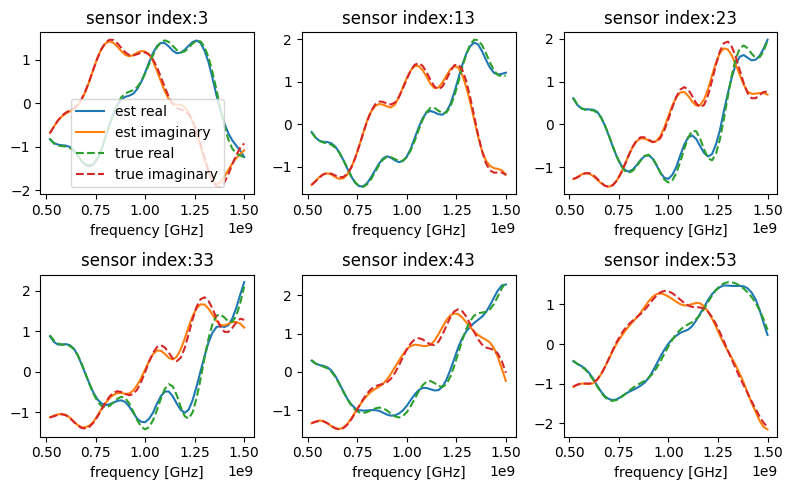

In [22]:
model = (torch.load(os.path.join(model_archive_path, "forward_model/fno_{}__layer_num_{}/fno_{}_{}_128_350_50_current.pth".format(model_type, layer_num, model_type, layer_num)), weights_only=False,  map_location=device)).to(device)
model.eval()

test_sample_index = 0 # can be 0 to 49 (we have 50 test samples in our dataset)
filename = "module_3_evaluation_{}_{}_Brown_winter_school_2025.png".format(last_name, first_name)

# Compare model output and test data (17 seconds on Google Colab CPU)
src_z = 56
with torch.no_grad():
    for i, (x,y) in enumerate(test_loader):
        if i==test_sample_index:
            x, y = x.to(device), y.to(device)
            batch_size = x.shape[0]
            out = model(x).reshape(batch_size, grid_nx, grid_ny, 2)
            out = out.detach().cpu().numpy()
            y = y.detach().cpu().numpy()

            plt.figure(figsize=[8, 5])
            for idx,src_x in enumerate(range(3, 60, 10)):
                plt.subplot(2, 3, idx+1)
                plt.plot(freq_grid, out[:,src_z,src_x,0], label='est real')
                plt.plot(freq_grid, out[:,src_z,src_x,1], label='est imaginary')

                plt.plot(freq_grid, y[:,src_z,src_x,0],"--", label='true real')
                plt.plot(freq_grid, y[:,src_z,src_x,1],"--", label='true imaginary')
                plt.title("sensor index:{}".format(src_x))
                plt.xlabel('frequency [GHz]')
                if idx == 0:
                    plt.legend()
            plt.tight_layout()
            plt.savefig(os.path.join(local_save_folder_path, filename))
            break

# Inverse problem

In [23]:
# Define objective function for optimization
def total_variation_loss(img, weight, type="isotropic"):
    if type == "isotropic":
        img = img.permute(0, 3, 1, 2)
        bs_img, c_img, h_img, w_img = img.size()
        tv_h = torch.pow(img[:, :, 1:, 1:] - img[:, :, :-1, 1:], 2)
        tv_w = torch.pow(img[:, :, 1:, 1:] - img[:, :, 1:, :-1], 2)
        return weight * ((torch.sqrt(tv_h + tv_w)).sum()) / (bs_img * c_img * h_img * w_img)

def inverse_objective(prediction, target, mask=torch.tensor(1), estimate_par=None, tv_reg=0):
    if tv_reg == 0:
        tvloss = 0
    else:
        tvloss = total_variation_loss(estimate_par, weight=tv_reg)
    if len(mask.shape) > 1:
        return {"mse": ((prediction * mask - target) ** 2).sum() / (mask.sum()) / prediction.shape[0], "tv": tvloss}
    return {"mse": ((prediction * mask - target) ** 2).mean(), "tv": tvloss}

In [24]:
# Load pretrained forward model
layer_num = 5
model_path = os.path.join(model_archive_path, "forward_model/fno_born__layer_num_{}/fno_born_{}_128_350_50_current.pth".format(layer_num, layer_num))
model = (torch.load(model_path, weights_only=False,  map_location=device)).to(device)
model.eval()

FNO2d_weight_tight_born(
  (fc_inc): Linear(in_features=4, out_features=128, bias=True)
  (fc_eps): Linear(in_features=3, out_features=128, bias=True)
  (conv0): SpectralConv2d_born()
  (w0): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
  (w1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

In [25]:
# Load pretrained prior (a generative model)
sys.path.append(os.path.join(full_module_path, "prior"))
prior_path = os.path.join(model_archive_path, "prior/model_final.pth")
import encoder_model
prior = encoder_model.ConvAutoencoder(1, 64).to(device)
prior.load_state_dict(torch.load(prior_path, weights_only=False,  map_location=device))
prior.eval()

ConvAutoencoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): 

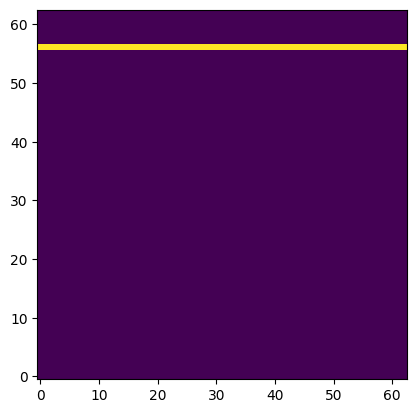

In [26]:
# generate mask for selecting sensor locations
src_z = 56
mask = torch.zeros([63,63,2])
mask[src_z,:,:] = 1
plt.imshow(mask[:,:,0], origin='lower')

In [27]:
def solve_inverse_frequency(
    model,
    incident_field,
    gt_dynamics,
    loss_fn,
    mask=1,
    num_iter=1000,
    prior=None,
    device="cuda",
    lr=1e-4,
    gt_eps=None,
    x_normalizer=None,
    y_normalizer=None,
    tv_reg=0,
    pivit_iter=200,
    use_filter=False,
    gamma=1,
):
    """
    model: the forward model
    incident_model: the real and imaginary parts of incident field: num_freq*N*N*2
    gt_dynmaics: the ground truth frequency field at each frequency: num_freq*N*N*2
    mask: measurements mask: num_freq*N*N*2
    num_iter: number of iteration for optimization
    prior: prior for eps
    """
    gt_eps = gt_eps.to(device)
    gt_dynamics = gt_dynamics.to(device)
    mask = mask.to(device)
    gt_eps_denorm = x_normalizer.decode(gt_eps.cpu())

    num_f, nx, nz, _ = gt_dynamics.shape
    freq_batch_size = int(num_f / 10)
    num_f_list = np.linspace(10, num_f, freq_batch_size)
    repeat = int(num_iter / freq_batch_size)
    num_f_list = np.repeat(num_f_list, repeat)

    class estimated_par(torch.nn.Module):
        def __init__(self):
            super(estimated_par, self).__init__()
            self.estimated_par = torch.nn.Parameter(
                (torch.zeros([1, prior.latent_dim]).to(device)), requires_grad=True
            ).to(device)

    observation = mask * gt_dynamics # sensor positions are determined by mask
    par = estimated_par().to(device) # the latent space parameters z of the generator G is to be optimized; estimated permittivity is G(z)
    optim = torch.optim.AdamW(params=par.parameters(), lr=lr)
    schedular = torch.optim.lr_scheduler.StepLR(optim, 1, gamma=gamma, last_epoch=-1)

    hist_loss = []
    hist_mse = []
    hist_mse_decoded = []
    hist_estimated_eps = []

    with tqdm(total=num_iter) as pbar:

        for total_steps in range(num_iter):
            num_f_t = num_f_list[min(num_iter - 1, total_steps)]
            num_f_t = int(num_f_t)
            estimated_eps = prior.decode(par.estimated_par)
            if use_filter:
                if num_f_t <= 10:
                    blur = torchvision.transforms.GaussianBlur(kernel_size=(7, 9)).to(device)
                    estimated_eps = blur(estimated_eps)
                elif num_f <= 30:
                    blur = torchvision.transforms.GaussianBlur(kernel_size=(3, 6)).to(device)
                    estimated_eps = blur(estimated_eps)
                elif num_f <= 40:
                    blur = torchvision.transforms.GaussianBlur(kernel_size=(2, 3)).to(device)
                    estimated_eps = blur(estimated_eps)
            estimated_eps = estimated_eps.permute(0, 2, 3, 1)
            currnet_input = torch.cat(
                [estimated_eps.repeat([num_f_t, 1, 1, 1]), incident_field[:num_f_t, :, :, :].to(device)], dim=-1
            )
            estimated_dynamic = model(currnet_input).reshape(num_f_t, 63, 63, 2)
            losses = loss_fn(
                estimated_dynamic, observation[:num_f_t, :, :, :], mask, estimate_par=estimated_eps, tv_reg=tv_reg
            )
            loss_t = 0
            for key in losses.keys():
                loss_t += losses[key]
            optim.zero_grad()
            loss_t.backward()

            hist_loss.append(loss_t.detach().cpu().numpy())

            hist_mse.append(((estimated_eps - gt_eps) ** 2).mean().detach().cpu().numpy())

            estimate_eps_denorm = x_normalizer.decode(estimated_eps.cpu())
            hist_mse_decoded.append(((gt_eps_denorm[:, :, 0] - estimate_eps_denorm[:, :, :, 0]) ** 2).mean().detach().cpu().numpy())

            torch.nn.utils.clip_grad_norm_(par.parameters(), 0.01)
            optim.step()
            pbar.update(1)

            if total_steps == pivit_iter:
                print("start piviting") # fine-tune generator network parameters
                optim = torch.optim.Adam(
                    [{"params": prior.parameters(), "lr": 1e-6}, {"params": par.parameters(), "lr": lr}]
                )

            if total_steps % 500 == 0:
                schedular.step()

            if (total_steps % 50 == 0) | (total_steps == num_iter-1):
                hist_estimated_eps.append(estimated_eps.detach().cpu())

            if (total_steps % repeat == 0) | (total_steps == num_iter-1):
                print("use {} frequenies".format(num_f_t))
                plt.figure()
                plt.subplot(131)
                plt_colorbar(gt_eps_denorm[:, :, 0].squeeze().detach().cpu().numpy(), vmin=1, vmax=10)
                plt.title("gt")
                plt.subplot(132)
                plt_colorbar(estimate_eps_denorm[:, :, :, 0].squeeze().detach().cpu().numpy(), vmin=1, vmax=10)
                plt.title("eps mse:{:.2f}, use{}".format(hist_mse_decoded[-1], num_f_t))

                plt.subplot(133)
                diff = (
                    estimate_eps_denorm[:, :, :, 0].squeeze().detach().cpu().numpy()
                    - gt_eps_denorm[:, :, 0].squeeze().detach().cpu().numpy()
                )
                plt_colorbar(diff, vmin=diff.max(), vmax=-1 * (diff.max()), cmap="seismic")
                plt.title("iter:{}, diff".format(total_steps))
                plt.tight_layout()

                print("eps mse:{:.2f}, u mse:{:.8f}".format(hist_mse_decoded[-1], loss_t))

    return hist_estimated_eps, hist_loss, hist_mse, hist_mse_decoded

It will take 8 minutes to complete on Google Colab CPU.
We recommend that you try it when you have access to GPU and use the cuda setting. It will take about 1 minute with much better reconstruction result.


  0%|          | 0/100 [00:00<?, ?it/s]

use 10 frequenies
eps mse:1.63, u mse:0.11878949
use 10 frequenies
eps mse:1.02, u mse:0.00393761


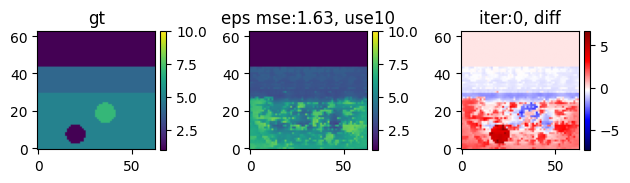

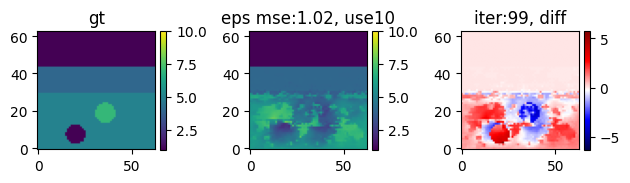

In [33]:
# get one test sample for demo
sample_select = 0  # can be 0 - 49
for i, (x,y) in enumerate(test_loader):
    if i==sample_select:
        break

if device=="cuda":
  gt_dynamics = y
  incident_field = x[:,:,:,1:]
  num_iter = 1200
  use_filter = True
elif device=="cpu": # only use a subset of frequencies on CPU
  freq_downsample = 5
  gt_dynamics = y[::freq_downsample, :, :, :]
  incident_field = x[::freq_downsample,:,:,1:]
  num_iter = 100
  use_filter = False
  print("It will take 8 minutes to complete on Google Colab CPU.")
  print("We recommend that you try it when you have access to GPU and use the cuda setting. It will take about 1 minute with much better reconstruction result.")
else:
  raise NotImplementedError("Please set 'device' to 'cpu' or 'cuda'")

gt_eps = x[0,:,:,[0]] # for computing MSE; not used in algorithm
loss_fn = partial(inverse_objective)


hist_estimated_eps, hist_loss, hist_mse, hist_mse_decoded = solve_inverse_frequency(model, incident_field, gt_dynamics, loss_fn, mask=mask,
                            num_iter=num_iter, prior=prior, device=device, lr = 0.002, gt_eps=gt_eps,
                            x_normalizer=x_normalizer, y_normalizer=y_normalizer, pivit_iter=300, tv_reg=0.01, use_filter=use_filter, gamma=0.5)

final latent mse:0.2316, final eps mse:1.0152


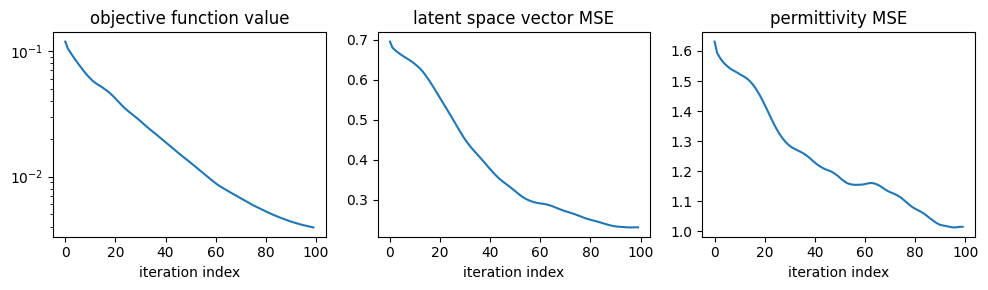

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[10, 3])
ax[0].semilogy(hist_loss)
ax[0].set_title('objective function value')
ax[1].plot(hist_mse)
ax[1].set_title('latent space vector MSE')
ax[2].plot(hist_mse_decoded)
ax[2].set_title('permittivity MSE')
for i in range(3):
    ax[i].set_xlabel('iteration index')
plt.tight_layout()
print("final latent mse:{:.4f}, final eps mse:{:.4f}".format(hist_mse[-1], hist_mse_decoded[-1]))

In [30]:
estimated_eps_final = hist_estimated_eps[-1]
currnet_input = torch.cat(
    [estimated_eps_final.repeat([incident_field.shape[0], 1, 1, 1]), incident_field], dim=-1
)
estimated_dynamic = model(currnet_input).reshape(incident_field.shape[0], grid_nx, grid_ny, 2)

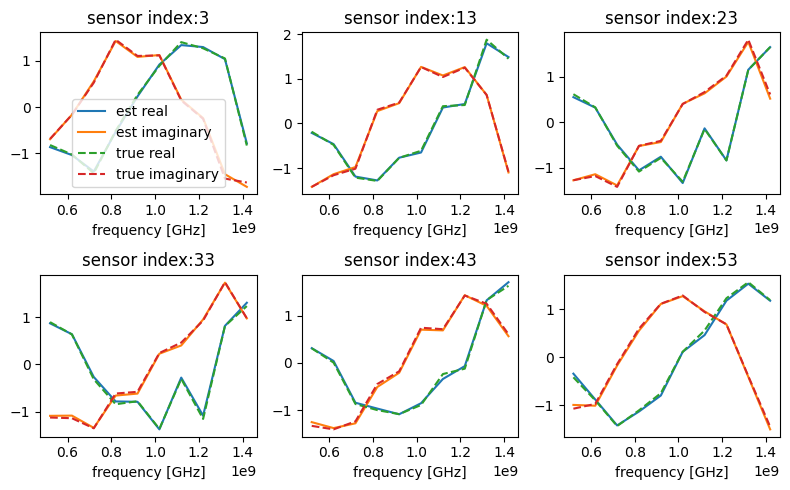

In [31]:
plt.figure(figsize=[8, 5])
for idx,src_x in enumerate(range(3,60,10)):
    plt.subplot(2, 3, idx+1)
    plt.plot(freq_grid[::freq_downsample], estimated_dynamic[:,src_z,src_x,0].detach().cpu().numpy(), label='est real')
    plt.plot(freq_grid[::freq_downsample], estimated_dynamic[:,src_z,src_x,1].detach().cpu().numpy(), label='est imaginary')

    plt.plot(freq_grid[::freq_downsample], gt_dynamics[:,src_z,src_x,0].detach().cpu().numpy(),"--", label='true real')
    plt.plot(freq_grid[::freq_downsample], gt_dynamics[:,src_z,src_x,1].detach().cpu().numpy(),"--", label='true imaginary')
    plt.title("sensor index:{}".format(src_x))
    plt.xlabel('frequency [GHz]')
    if idx == 0:
        plt.legend()
plt.tight_layout()

The more comprehensive code and better pre-trained moddel is available at: https://github.com/merlresearch/DeepBornFNO